In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import graphviz
import joblib
from tqdm import tqdm

%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, cross_validate, RandomizedSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import tree

from scipy import stats

import xgboost as xgb

import torch

## Load Dataset

In [3]:
df = pd.read_csv("./data/medicalpremium.csv")
df["PremiumPrice"] = df["PremiumPrice"] * 0.056
df

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
0,45,0,0,0,0,155,57,0,0,0,1400.0
1,60,1,0,0,0,180,73,0,0,0,1624.0
2,36,1,1,0,0,158,59,0,0,1,1288.0
3,52,1,1,0,1,183,93,0,0,2,1568.0
4,38,0,0,0,1,166,88,0,0,1,1288.0
...,...,...,...,...,...,...,...,...,...,...,...
981,18,0,0,0,0,169,67,0,0,0,840.0
982,64,1,1,0,0,153,70,0,0,3,1568.0
983,56,0,1,0,0,155,71,0,0,1,1624.0
984,47,1,1,0,0,158,73,1,0,1,2184.0


In [4]:
feature_names = df.drop("PremiumPrice", axis=1).columns.to_list()

## Exploratory Data Analysis

In [5]:
df.describe()

,Age,Diabetes,BloodPressureProblems,AnyTransplants,AnyChronicDiseases,Height,Weight,KnownAllergies,HistoryOfCancerInFamily,NumberOfMajorSurgeries,PremiumPrice
count,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000,986.000000
mean,41.745436,0.419878,0.468560,0.055781,0.180527,168.182556,76.950304,0.215010,0.117647,0.667343,1362.855984
std,13.963371,0.493789,0.499264,0.229615,0.384821,10.098155,14.265096,0.411038,0.322353,0.749205,349.898325
min,18.000000,0.000000,0.000000,0.000000,0.000000,145.000000,51.000000,0.000000,0.000000,0.000000,840.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,161.000000,67.000000,0.000000,0.000000,0.000000,1176.000000
50%,42.000000,0.000000,0.000000,0.000000,0.000000,168.000000,75.000000,0.000000,0.000000,1.000000,1288.000000
75%,53.000000,1.000000,1.000000,0.000000,0.000000,176.000000,87.000000,0.000000,0.000000,1.000000,1568.000000
max,66.000000,1.000000,1.000000,1.000000,1.000000,188.000000,132.000000,1.000000,1.000000,3.000000,2240.000000


## Data Preparation

In [6]:
X = df.drop("PremiumPrice", axis=1).to_numpy()
y_true = df["PremiumPrice"].to_numpy()

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
joblib.dump(scaler, "models/standard_scaler.joblib")
scaler_load = joblib.load("models/standard_scaler.joblib")
np.all(scaler_load.transform(X) == X_scaled)

True

In [9]:
X

array([[45,  0,  0, ...,  0,  0,  0],
       [60,  1,  0, ...,  0,  0,  0],
       [36,  1,  1, ...,  0,  0,  1],
       ...,
       [56,  0,  1, ...,  0,  0,  1],
       [47,  1,  1, ...,  1,  0,  1],
       [21,  0,  0, ...,  1,  0,  1]], dtype=int64)

In [10]:
X_scaled

array([[ 0.23319694, -0.85075039, -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [ 1.30798124,  1.1754329 , -0.93897784, ..., -0.52335629,
        -0.36514837, -0.89118667],
       [-0.41167363,  1.1754329 ,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       ...,
       [ 1.02137209, -0.85075039,  1.06498786, ..., -0.52335629,
        -0.36514837,  0.44423895],
       [ 0.37650152,  1.1754329 ,  1.06498786, ...,  1.9107442 ,
        -0.36514837,  0.44423895],
       [-1.48645793, -0.85075039, -0.93897784, ...,  1.9107442 ,
        -0.36514837,  0.44423895]])

## Model Comparison

> Choosing `Decision Tree` for its explainability and `Neural Network` for showing its black box nature

### Standardization

#### Tree-based methods

In [11]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=35368.25; r2=0.71
mse=34146.98; r2=0.72


In [12]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=24199.00; r2=0.80
mse=24148.96; r2=0.80


In [13]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=29714.54; r2=0.76
mse=29853.29; r2=0.76


#### Others

In [14]:
lin_reg = LinearRegression()

res_dict = cross_validate(lin_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(lin_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=44829.84; r2=0.63
mse=44829.84; r2=0.63


In [15]:
sgd_reg = SGDRegressor()

res_dict = cross_validate(sgd_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(sgd_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=138887626920213070605189120.00; r2=-1058154474567481163776.00
mse=44860.40; r2=0.63


In [16]:
svm_reg = SVR()

res_dict = cross_validate(svm_reg, X, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(svm_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=122705.52; r2=-0.01
mse=108699.04; r2=0.11


> Standardization is not needed in tree-based methods (boost performance in general); needed in other methods

### Choosing the right explained variance ratio for PCA

The explained variance ratio is the percentage of variance that is attributed by each of the selected components.

Text(0.5, 1.0, 'The number of components needed to retain 90% variance explained')

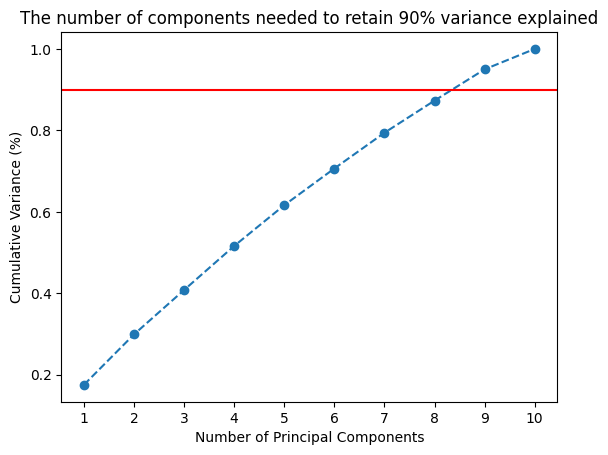

In [17]:
pca = PCA()
X_reduced = pca.fit_transform(X_scaled)
exp_var = pca.explained_variance_ratio_
cum_sum_eigvals = np.cumsum(exp_var)

plt.plot(range(1, len(cum_sum_eigvals) + 1), cum_sum_eigvals, marker="o", linestyle="--")
plt.axhline(y=0.9, color="r", linestyle="-")
plt.xticks(range(1, len(cum_sum_eigvals) + 1))
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance (%)")
plt.title("The number of components needed to retain 90% variance explained")

In [18]:
pca = PCA(n_components=0.9) # retain 0.9 variance explained
X_reduced = pca.fit_transform(X_scaled)

In [19]:
X_reduced.shape

(986, 9)

In [20]:
dt_reg = DecisionTreeRegressor()

res_dict = cross_validate(dt_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=95102.48; r2=0.22
mse=36573.69; r2=0.70


In [21]:
rf_reg = RandomForestRegressor()

res_dict = cross_validate(rf_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=48855.01; r2=0.60
mse=23989.02; r2=0.80


In [22]:
xgb_reg = xgb.XGBRegressor()

res_dict = cross_validate(xgb_reg, X_reduced, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5)
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")

mse=53484.80; r2=0.56
mse=29853.29; r2=0.76


> PCA doesn't help to improve the performance in tree-based methods

In [56]:
# Save training and validation loss of each model
loss_dict = {
    "train": {
        "dt_reg": None,
        "rf_reg": None,
        "xgb_reg": None,
        "mlp_reg": None,
    },
    "valid": {
        "dt_reg": None,
        "rf_reg": None,
        "xgb_reg": None,
        "mlp_reg": None,
    }
}

loss_dict

{'train': {'dt_reg': None, 'rf_reg': None, 'xgb_reg': None, 'mlp_reg': None},
 'valid': {'dt_reg': None, 'rf_reg': None, 'xgb_reg': None, 'mlp_reg': None}}

#### Decision Tree

In [23]:
# Baseline
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=15)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=0.00; r2=1.00
mse=33782.55; r2=0.72
[-0. -0. -0. -0. -0.]
[-41053.09090909 -35785.4213198  -25756.58883249 -34352.73096447
 -31964.91370558]


To reduce overfitting of Decision Tree
- set max depth
- pruning
- set min number of samples required at leaf nodes

In [24]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(DecisionTreeRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-21999.986 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-32313.308 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-20283.557 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-16675.187 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-47070.619 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-22183.542 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-29057.035 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-17146.277 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-18918.414 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-43603.463 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-22205.101 total time=   0.0s
[CV 2/5

[CV 5/5] END max_depth=7, min_samples_leaf=18;, score=-46453.866 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=4;, score=-28692.864 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=4;, score=-31880.550 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=4;, score=-18254.256 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=4;, score=-19277.664 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=4;, score=-47640.240 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=2;, score=-24135.373 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=2;, score=-32384.271 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=2;, score=-26405.225 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=2;, score=-19713.101 total time=   0.0s
[CV 5/5] END max_depth=7, min_samples_leaf=2;, score=-39029.346 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=11;, score=-19700.610 total time=   0.

[CV 1/5] END max_depth=11, min_samples_leaf=3;, score=-31082.003 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=3;, score=-34149.510 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=3;, score=-24518.854 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=3;, score=-23343.434 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=3;, score=-47350.089 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=14;, score=-24504.092 total time=   0.0s
[CV 2/5] END max_depth=14, min_samples_leaf=14;, score=-33173.620 total time=   0.0s
[CV 3/5] END max_depth=14, min_samples_leaf=14;, score=-19208.158 total time=   0.0s
[CV 4/5] END max_depth=14, min_samples_leaf=14;, score=-17133.854 total time=   0.0s
[CV 5/5] END max_depth=14, min_samples_leaf=14;, score=-44532.622 total time=   0.0s
[CV 1/5] END max_depth=13, min_samples_leaf=7;, score=-23761.857 total time=   0.0s
[CV 2/5] END max_depth=13, min_samples_leaf=7;, score=-29395.322 total 

[CV 1/5] END max_depth=6, min_samples_leaf=6;, score=-23315.996 total time=   0.0s
[CV 2/5] END max_depth=6, min_samples_leaf=6;, score=-35838.100 total time=   0.0s
[CV 3/5] END max_depth=6, min_samples_leaf=6;, score=-19289.407 total time=   0.0s
[CV 4/5] END max_depth=6, min_samples_leaf=6;, score=-20924.437 total time=   0.0s
[CV 5/5] END max_depth=6, min_samples_leaf=6;, score=-47702.006 total time=   0.0s
[CV 1/5] END max_depth=5, min_samples_leaf=2;, score=-22268.796 total time=   0.0s
[CV 2/5] END max_depth=5, min_samples_leaf=2;, score=-37196.519 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=2;, score=-26071.658 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=2;, score=-22339.278 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=2;, score=-49499.436 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=3;, score=-29178.207 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=3;, score=-33986.297 total time=   0.0s
[CV 

In [112]:
# Best model
dt_reg = DecisionTreeRegressor(random_state=42, max_depth=11, min_samples_leaf=10)

res_dict = cross_validate(dt_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=20219.25; r2=0.83
mse=25246.39; r2=0.79
[-21742.54285866 -19377.37159293 -21556.82832759 -22509.69050797
 -15909.81888523]
[-20208.8163144  -28801.21992126 -18401.69309145 -16513.29752733
 -42306.90662737]


In [113]:
loss_dict["train"]["dt_reg"] = np.abs(res_dict["train_neg_mean_squared_error"]).tolist()
loss_dict["valid"]["dt_reg"] = np.abs(res_dict["test_neg_mean_squared_error"]).tolist()

In [114]:
dt_reg.fit(X_scaled, y_true)

y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [106]:
joblib.dump(dt_reg, "models/decision_tree.joblib")
dt_reg = joblib.load("models/decision_tree.joblib")
y_pred = dt_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

19541.920421616032

In [111]:
dot_data = tree.export_graphviz(dt_reg, out_file=None, 
                                feature_names=feature_names, filled=True, label="all", rounded=True, proportion=True, max_depth=7)
graph = graphviz.Source(dot_data)
graph.render("res/dtree_viz", format="pdf")
graph.render("res/dtree_viz", format="svg")

'res\\dtree_viz.svg'

In [122]:
dt_reg.tree_.node_count

107

#### Random Forest

In [29]:
# Baseline
rf_reg = RandomForestRegressor(random_state=42)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=3541.50; r2=0.97
mse=23925.35; r2=0.80
[-4416.43596345 -3244.25758175 -3469.10798682 -3699.48633714
 -2878.18979772]
[-19982.22613333 -25490.84069036 -19637.39799391 -14170.58111675
 -40345.70337462]


To reduce overfitting of Random Forest
- set max depth
- set min number of samples required at leaf nodes

In [30]:
params_distr = {
    "max_depth": stats.randint(low=5, high=15),
    "min_samples_leaf": stats.randint(low=2, high=20)
}

rand_search_cv = RandomizedSearchCV(RandomForestRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=11, min_samples_leaf=16;, score=-27961.962 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=16;, score=-33917.845 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=16;, score=-21395.549 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=16;, score=-22669.481 total time=   0.0s
[CV 5/5] END max_depth=11, min_samples_leaf=16;, score=-44861.986 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=8;, score=-20955.760 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=8;, score=-30633.155 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=8;, score=-18095.927 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=8;, score=-15759.632 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=8;, score=-43456.719 total time=   0.0s
[CV 1/5] END max_depth=14, min_samples_leaf=12;, score=-23449.227 total time=   0.0s
[CV 2/5

[CV 3/5] END max_depth=14, min_samples_leaf=3;, score=-15928.167 total time=   0.0s
[CV 4/5] END max_depth=14, min_samples_leaf=3;, score=-14791.955 total time=   0.0s
[CV 5/5] END max_depth=14, min_samples_leaf=3;, score=-44590.931 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=16;, score=-26786.285 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=16;, score=-33673.305 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=16;, score=-21542.857 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=16;, score=-22816.254 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=16;, score=-44702.286 total time=   0.0s
[CV 1/5] END max_depth=11, min_samples_leaf=13;, score=-26060.226 total time=   0.0s
[CV 2/5] END max_depth=11, min_samples_leaf=13;, score=-32250.497 total time=   0.0s
[CV 3/5] END max_depth=11, min_samples_leaf=13;, score=-20181.060 total time=   0.0s
[CV 4/5] END max_depth=11, min_samples_leaf=13;, score=-20510.670 total t

[CV 1/5] END max_depth=13, min_samples_leaf=2;, score=-18399.197 total time=   0.1s
[CV 2/5] END max_depth=13, min_samples_leaf=2;, score=-26815.479 total time=   0.0s
[CV 3/5] END max_depth=13, min_samples_leaf=2;, score=-17473.587 total time=   0.0s
[CV 4/5] END max_depth=13, min_samples_leaf=2;, score=-14607.093 total time=   0.0s
[CV 5/5] END max_depth=13, min_samples_leaf=2;, score=-42739.210 total time=   0.0s
[CV 1/5] END max_depth=12, min_samples_leaf=12;, score=-24360.574 total time=   0.0s
[CV 2/5] END max_depth=12, min_samples_leaf=12;, score=-32166.375 total time=   0.0s
[CV 3/5] END max_depth=12, min_samples_leaf=12;, score=-19866.950 total time=   0.0s
[CV 4/5] END max_depth=12, min_samples_leaf=12;, score=-19257.208 total time=   0.0s
[CV 5/5] END max_depth=12, min_samples_leaf=12;, score=-43949.764 total time=   0.0s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-27573.783 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-34921.378 total 

[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16255.737 total time=   0.1s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43949.885 total time=   0.1s
[CV 1/5] END max_depth=5, min_samples_leaf=5;, score=-23155.074 total time=   0.1s
[CV 2/5] END max_depth=5, min_samples_leaf=5;, score=-34349.640 total time=   0.0s
[CV 3/5] END max_depth=5, min_samples_leaf=5;, score=-19810.060 total time=   0.0s
[CV 4/5] END max_depth=5, min_samples_leaf=5;, score=-21520.447 total time=   0.0s
[CV 5/5] END max_depth=5, min_samples_leaf=5;, score=-46917.475 total time=   0.0s
[CV 1/5] END max_depth=9, min_samples_leaf=8;, score=-20604.601 total time=   0.1s
[CV 2/5] END max_depth=9, min_samples_leaf=8;, score=-30279.465 total time=   0.0s
[CV 3/5] END max_depth=9, min_samples_leaf=8;, score=-18336.255 total time=   0.0s
[CV 4/5] END max_depth=9, min_samples_leaf=8;, score=-15975.005 total time=   0.0s
[CV 5/5] END max_depth=9, min_samples_leaf=8;, score=-43517.515 total time=   0.0s
[CV 

[CV 3/5] END max_depth=11, min_samples_leaf=3;, score=-16420.101 total time=   0.1s
[CV 4/5] END max_depth=11, min_samples_leaf=3;, score=-14991.800 total time=   0.1s
[CV 5/5] END max_depth=11, min_samples_leaf=3;, score=-44713.179 total time=   0.1s
[CV 1/5] END max_depth=7, min_samples_leaf=18;, score=-27791.377 total time=   0.0s
[CV 2/5] END max_depth=7, min_samples_leaf=18;, score=-35117.354 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=18;, score=-21963.960 total time=   0.0s
[CV 4/5] END max_depth=7, min_samples_leaf=18;, score=-23947.359 total time=   0.1s
[CV 5/5] END max_depth=7, min_samples_leaf=18;, score=-47911.400 total time=   0.1s
[CV 1/5] END max_depth=9, min_samples_leaf=18;, score=-28330.416 total time=   0.1s
[CV 2/5] END max_depth=9, min_samples_leaf=18;, score=-34953.302 total time=   0.1s
[CV 3/5] END max_depth=9, min_samples_leaf=18;, score=-21236.566 total time=   0.1s
[CV 4/5] END max_depth=9, min_samples_leaf=18;, score=-24678.116 total time=

[CV 2/5] END max_depth=7, min_samples_leaf=8;, score=-31135.874 total time=   0.0s
[CV 3/5] END max_depth=7, min_samples_leaf=8;, score=-18762.796 total time=   0.1s
[CV 4/5] END max_depth=7, min_samples_leaf=8;, score=-16688.092 total time=   0.1s
[CV 5/5] END max_depth=7, min_samples_leaf=8;, score=-43698.978 total time=   0.0s
[CV 1/5] END max_depth=8, min_samples_leaf=10;, score=-22639.553 total time=   0.0s
[CV 2/5] END max_depth=8, min_samples_leaf=10;, score=-31632.598 total time=   0.0s
[CV 3/5] END max_depth=8, min_samples_leaf=10;, score=-18778.785 total time=   0.0s
[CV 4/5] END max_depth=8, min_samples_leaf=10;, score=-17014.099 total time=   0.0s
[CV 5/5] END max_depth=8, min_samples_leaf=10;, score=-44487.824 total time=   0.1s
{'max_depth': 13, 'min_samples_leaf': 2} -24006.913350762108


In [64]:
# Best model
rf_reg = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=13, min_samples_leaf=2)

res_dict = cross_validate(rf_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=9236.78; r2=0.92
mse=24251.72; r2=0.80
[-10967.08111262  -8586.95332676  -9238.49401585  -9920.28903802
  -7471.08340804]
[-19869.69727411 -27198.12723039 -16994.85260711 -14276.81429929
 -42919.12716701]


In [65]:
loss_dict["train"]["rf_reg"] = np.abs(res_dict["train_neg_mean_squared_error"]).tolist()
loss_dict["valid"]["rf_reg"] = np.abs(res_dict["test_neg_mean_squared_error"]).tolist()

In [32]:
rf_reg.fit(X_scaled, y_true)

y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

In [33]:
joblib.dump(rf_reg, "models/random_forest.joblib")
rf_reg = joblib.load("models/random_forest.joblib")
y_pred = rf_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

#### XGBoost

In [34]:
# Base model
xgb_reg = xgb.XGBRegressor(random_state=42)

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=51.28; r2=1.00
mse=29853.29; r2=0.76
[-44.27394932 -46.40766175 -56.80664894 -57.71157656 -51.20805784]
[-23197.10270789 -32575.80950734 -20718.23839519 -22294.44849346
 -50480.83584757]


In [35]:
params_distr = {
    'n_estimators': [100, 400, 800],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.05, 0.1, 0.20],
    'min_child_weight': [1, 10, 100]
}

rand_search_cv = RandomizedSearchCV(xgb.XGBRegressor(), params_distr, random_state=42, verbose=6,
                                    cv=5, scoring="neg_mean_squared_error",
                                    n_iter=100)
rand_search = rand_search_cv.fit(X_scaled, y_true)
print(rand_search.best_params_, rand_search.best_score_)

C:\Users\Jia Herng\AppData\Local\pypoetry\Cache\virtualenvs\model-dev-J5QNXlQH-py3.10\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 81 is smaller than n_iter=100. Running 81 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-22995.533 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-32038.563 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-20327.060 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-17511.621 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=100;, score=-48635.563 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=400;, score=-26665.502 total time=   0.0s
[CV 2/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=400;, score=-32768.052 total time=   0.0s
[CV 3/5] END learning_rate=0.05, max_depth=3, min_child_weight=1, n_estimators=400;, score=

[CV 3/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=-17706.428 total time=   0.0s
[CV 4/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=-18204.492 total time=   0.0s
[CV 5/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=400;, score=-46370.841 total time=   0.0s
[CV 1/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=-26268.429 total time=   0.2s
[CV 2/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=-36707.148 total time=   0.2s
[CV 3/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=-19206.727 total time=   0.1s
[CV 4/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=-20416.347 total time=   0.1s
[CV 5/5] END learning_rate=0.05, max_depth=6, min_child_weight=10, n_estimators=800;, score=-47617.700 total time=   0.2s
[CV 1/5] END learning_ra

[CV 1/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400;, score=-31068.465 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400;, score=-33713.205 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400;, score=-20440.446 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400;, score=-19971.073 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=400;, score=-48176.358 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=800;, score=-33243.450 total time=   0.1s
[CV 2/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=800;, score=-34155.121 total time=   0.1s
[CV 3/5] END learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=800;, score=-20627.956 total time=   0.1s
[CV 4/5] END learning_rate=0.1, max_dept

[CV 4/5] END learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=800;, score=-24088.639 total time=   0.2s
[CV 5/5] END learning_rate=0.1, max_depth=6, min_child_weight=10, n_estimators=800;, score=-48415.610 total time=   0.2s
[CV 1/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=100;, score=-46521.319 total time=   0.0s
[CV 2/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=100;, score=-48177.857 total time=   0.0s
[CV 3/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=100;, score=-29761.426 total time=   0.0s
[CV 4/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=100;, score=-36274.448 total time=   0.0s
[CV 5/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=100;, score=-62694.463 total time=   0.0s
[CV 1/5] END learning_rate=0.1, max_depth=6, min_child_weight=100, n_estimators=400;, score=-49473.176 total time=   0.0s
[CV 2/5] END learning_rate

[CV 3/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400;, score=-19637.111 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400;, score=-21134.770 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=400;, score=-51354.625 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800;, score=-35476.840 total time=   0.1s
[CV 2/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800;, score=-35652.273 total time=   0.1s
[CV 3/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800;, score=-21718.751 total time=   0.1s
[CV 4/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800;, score=-22772.559 total time=   0.2s
[CV 5/5] END learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=800;, score=-55142.386 total time=   0.1s
[CV 1/5] END learning_rate=0.2, max_dept

[CV 1/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=400;, score=-51298.647 total time=   0.0s
[CV 2/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=400;, score=-50779.177 total time=   0.0s
[CV 3/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=400;, score=-34568.618 total time=   0.0s
[CV 4/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=400;, score=-39145.654 total time=   0.0s
[CV 5/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=400;, score=-60172.552 total time=   0.0s
[CV 1/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=800;, score=-54344.834 total time=   0.2s
[CV 2/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=800;, score=-55082.318 total time=   0.2s
[CV 3/5] END learning_rate=0.2, max_depth=6, min_child_weight=100, n_estimators=800;, score=-37596.788 total time=   0.1s
[CV 4/5] END learning_ra

In [66]:
# Best model
xgb_reg = xgb.XGBRegressor(n_estimators=100, min_child_weight=10, max_depth=9, learning_rate=0.05, random_state=42)

res_dict = cross_validate(xgb_reg, X_scaled, y_true, scoring=["neg_mean_squared_error", "r2"], cv=5, return_train_score=True)
print(f"mse={np.abs(np.mean(res_dict['train_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['train_r2']):.2f}")
print(f"mse={np.abs(np.mean(res_dict['test_neg_mean_squared_error'])):.2f}; r2={np.mean(res_dict['test_r2']):.2f}")
print(res_dict["train_neg_mean_squared_error"])
print(res_dict["test_neg_mean_squared_error"])

mse=10918.43; r2=0.91
mse=24978.94; r2=0.80
[-11691.62375153 -10786.4874782  -11592.64515789 -12058.38308878
  -8463.03067381]
[-20382.56213501 -27143.40309156 -16840.87593962 -15598.3374432
 -44929.50966358]


In [67]:
loss_dict["train"]["xgb_reg"] = np.abs(res_dict["train_neg_mean_squared_error"]).tolist()
loss_dict["valid"]["xgb_reg"] = np.abs(res_dict["test_neg_mean_squared_error"]).tolist()

In [39]:
xgb_reg.fit(X_scaled, y_true)

y_pred = xgb_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

10933.52384995674

In [40]:
joblib.dump(rf_reg, "models/xgboost.joblib")
xgb_reg = joblib.load("models/xgboost.joblib")
y_pred = xgb_reg.predict(X_scaled)
mean_squared_error(y_true, y_pred)

8963.396112943366

#### Neural Network

In [41]:
def train(X_train, y_train, X_valid, y_valid, model, n_epochs=1000, lr=0.03, verbose=False):
    
    history = {"loss_train": [], "loss_valid": []}
    
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(n_epochs):
        model.train()
        # Forward pass
        y_pred_train = model(X_train)
        loss_train = criterion(y_pred_train, y_train)
        
        # Backward pass
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        
        # Model evaluation
        with torch.no_grad():
            model.eval()
            y_pred_valid = model(X_valid)
            loss_valid = criterion(y_pred_valid, y_valid)
            
        if epoch % 100 == 0:
            history["loss_train"].append(loss_train.item())
            history["loss_valid"].append(loss_valid.item())
        
        if verbose and epoch % 1000 == 0:
            tqdm.write(f'Epoch [{epoch}/{n_epochs}], Training loss: {loss_train.item():.4f}, Validation loss: {loss_valid.item():.4f}')
       
    return history

In [42]:
X_pt = torch.tensor(X_scaled, dtype=torch.float32)
y_pt = torch.tensor(y_true, dtype=torch.float32).view(-1, 1)

In [43]:
X_train, X_valid, y_train, y_valid = train_test_split(X_pt, y_pt, test_size=0.2)

In [44]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train, y_train, X_valid, y_valid, mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1974412.0000, Validation loss: 1996889.8750
Epoch [1000/10000], Training loss: 82281.0625, Validation loss: 44664.7734
Epoch [2000/10000], Training loss: 87050.0312, Validation loss: 44955.1836
Epoch [3000/10000], Training loss: 84559.5469, Validation loss: 46032.5742
Epoch [4000/10000], Training loss: 71340.6406, Validation loss: 37822.7148
Epoch [5000/10000], Training loss: 66681.5156, Validation loss: 37640.3398
Epoch [6000/10000], Training loss: 66093.8047, Validation loss: 39192.2227
Epoch [7000/10000], Training loss: 64438.9141, Validation loss: 40304.6094
Epoch [8000/10000], Training loss: 61320.9648, Validation loss: 41972.3281
Epoch [9000/10000], Training loss: 55607.2773, Validation loss: 41162.7656


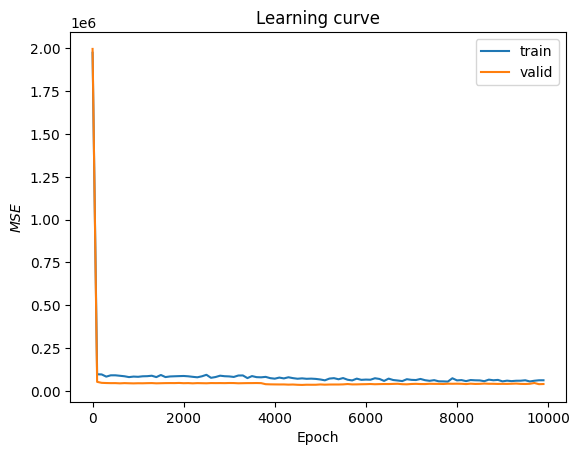

In [45]:
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_train"], label="train")
plt.plot(np.arange(0, len(history["loss_train"])) * 100, history["loss_valid"], label="valid")
plt.legend()
plt.title("Learning curve")
plt.ylabel(r"$MSE$")
plt.xlabel("Epoch")
plt.show()

In [46]:
# K-fold cross validation
mse_train = []
mse_test = []

for train_idx, test_idx in KFold(n_splits=5, shuffle=True).split(X_pt, y_pt):
    
    # Get train and test data for k-th fold
    X_train_fold = X_pt[train_idx]
    y_train_fold = y_pt[train_idx]
    X_test_fold = X_pt[test_idx]
    y_test_fold = y_pt[test_idx]
    
    # Define model
    mlp = torch.nn.Sequential(
        torch.nn.Linear(10, 32),
        torch.nn.ReLU(),
        torch.nn.Linear(32, 16),
        torch.nn.ReLU(),
        torch.nn.Linear(16, 8),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.1),
        torch.nn.Linear(8, 1)
    )
    
    # Train model on k-th fold training data
    history = train(X_train=X_train_fold, y_train=y_train_fold, 
          X_valid=X_test_fold, y_valid=y_test_fold, 
          model=mlp, n_epochs=10000, lr=0.03, verbose=False)
    
    mse_train.append(history["loss_train"][-1])
    mse_test.append(history["loss_valid"][-1])

In [70]:
mse_train

[38122.3515625, 63769.04296875, 54072.171875, 69641.4609375, 54945.078125]

In [48]:
mse_test

[59303.9453125, 43665.1171875, 52284.33984375, 63221.0234375, 53107.84375]

In [50]:
np.mean(mse_train)

56110.02109375

In [49]:
np.mean(mse_test)

54316.45390625

In [71]:
loss_dict["train"]["mlp_reg"] = mse_train
loss_dict["valid"]["mlp_reg"] = mse_test

In [51]:
mlp = torch.nn.Sequential(
    torch.nn.Linear(10, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 16),
    torch.nn.ReLU(),
    torch.nn.Linear(16, 8),
    torch.nn.ReLU(),
    torch.nn.Dropout(p=0.1),
    torch.nn.Linear(8, 1)
)

history = train(X_train=X_pt, y_train=y_pt, X_valid=X_pt, y_valid=y_pt, model=mlp, n_epochs=10000, verbose=True)

Epoch [0/10000], Training loss: 1979275.0000, Validation loss: 1978770.0000
Epoch [1000/10000], Training loss: 82802.3516, Validation loss: 35161.4297
Epoch [2000/10000], Training loss: 96509.9531, Validation loss: 32780.1406
Epoch [3000/10000], Training loss: 80223.8047, Validation loss: 29639.9062
Epoch [4000/10000], Training loss: 83097.4297, Validation loss: 26482.6992
Epoch [5000/10000], Training loss: 75182.1641, Validation loss: 26260.6289
Epoch [6000/10000], Training loss: 74099.0859, Validation loss: 28398.4375
Epoch [7000/10000], Training loss: 62214.8359, Validation loss: 23872.6211
Epoch [8000/10000], Training loss: 64870.8594, Validation loss: 23294.8984
Epoch [9000/10000], Training loss: 62298.9883, Validation loss: 23217.7617


In [52]:
print(mlp)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)


In [53]:
torch.save(mlp, "models/mlp.pt")

In [54]:
mlp = torch.load("models/mlp.pt")
mlp.eval()

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=8, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=8, out_features=1, bias=True)
)

In [55]:
y_pred = mlp(torch.tensor(X_scaled, dtype=torch.float32))
torch.nn.functional.mse_loss(y_pred, torch.tensor(y_true, dtype=torch.float32).view(-1, 1)).item()

22841.69921875

In [72]:
loss_dict

{'train': {'dt_reg': [21742.542858661214,
   19377.37159293001,
   21556.82832758966,
   22509.690507974512,
   15909.81888522909],
  'rf_reg': [10967.081112622971,
   8586.953326759469,
   9238.494015849847,
   9920.289038020002,
   7471.083408043733],
  'xgb_reg': [11691.623751533525,
   10786.487478197272,
   11592.645157886709,
   12058.383088783157,
   8463.030673812578],
  'mlp_reg': [38122.3515625,
   63769.04296875,
   54072.171875,
   69641.4609375,
   54945.078125]},
 'valid': {'dt_reg': [20208.8163143957,
   28801.219921264215,
   18401.69309144717,
   16513.297527325212,
   42306.90662736841],
  'rf_reg': [19869.697274109025,
   27198.127230389724,
   16994.85260711119,
   14276.814299285828,
   42919.12716700783],
  'xgb_reg': [20382.562135013854,
   27143.403091556833,
   16840.875939623733,
   15598.337443202678,
   44929.509663575474],
  'mlp_reg': [59303.9453125,
   43665.1171875,
   52284.33984375,
   63221.0234375,
   53107.84375]}}

Text(0.5, 1.0, 'MSE Comparison between Models')

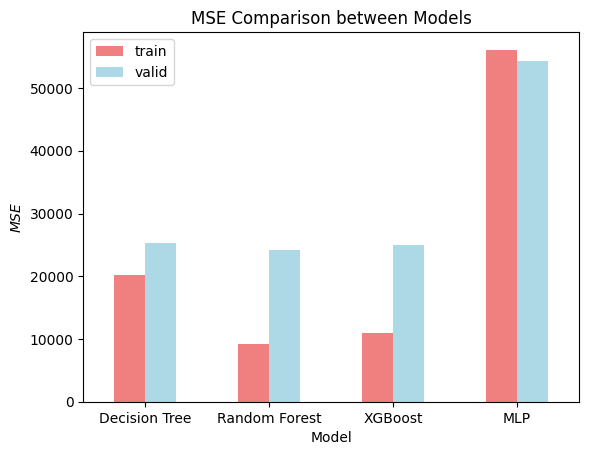

In [100]:
train_losses = [np.mean(loss_dict["train"][model_name]) for model_name in loss_dict["train"]]
valid_losses = [np.mean(loss_dict["valid"][model_name]) for model_name in loss_dict["valid"]]
model_names = ["Decision Tree", "Random Forest", "XGBoost", "MLP"]

df = pd.DataFrame({
    "train": train_losses,
    "valid": valid_losses,
}, index=model_names)
df.plot.bar(rot=0, color={"train": "lightcoral", "valid": "lightblue"})
plt.ylabel("$MSE$")
plt.xlabel("Model")
plt.title("MSE Comparison between Models")

In [88]:
list(loss_dict["train"].keys())

['dt_reg', 'rf_reg', 'xgb_reg', 'mlp_reg']